In [ ]:
print('hello world')

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import TweetTokenizer
from collections import defaultdict



In [2]:
dataset_path = 'sentiment_analysis.csv'
df = pd.read_csv(dataset_path, index_col='id')

df.shape

(7920, 2)

In [4]:
def text_normalize(text):
    # Retweet old acronym 'RT' removal
    text = re.sub(r'^RT[\s]+', '', text)

    # Hyperlink removal
    text = re.sub(r'https?:\/\/,*[\r\n]*', '', text)

    # Hashtag removal
    text = re.sub(r'#', '', text)

    # Punctuation removal
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    tokenizer = TweetTokenizer(
        preserve_case=False,
        strip_handles=True,
        reduce_len=True
    )

    text_tokens = tokenizer.tokenize(text)

    return text_tokens





In [9]:
def get_freqs(df):
    freqs = defaultdict(lambda: 0)

    for idx, row in df.iterrows():
        tweet = row['tweet']
        label = row['label']

        tokens = text_normalize(tweet)
        for token in tokens:
            pair = (token, label)
            freqs[pair] += 1

    return freqs

freqs = get_freqs(df)

freqs

defaultdict(<function __main__.get_freqs.<locals>.<lambda>()>,
            {('fingerprint', 0): 4,
             ('pregnancy', 0): 1,
             ('test', 0): 9,
             ('googlh', 0): 1,
             ('1mfqv', 0): 1,
             ('android', 0): 361,
             ('apps', 0): 124,
             ('beautiful', 0): 235,
             ('cute', 0): 327,
             ('health', 0): 118,
             ('igers', 0): 145,
             ('iphoneonly', 0): 133,
             ('iphonesia', 0): 138,
             ('iphone', 0): 3570,
             ('finally', 0): 168,
             ('a', 0): 754,
             ('transparant', 0): 1,
             ('silicon', 0): 1,
             ('case', 0): 270,
             ('thanks', 0): 100,
             ('to', 0): 880,
             ('my', 0): 1246,
             ('uncle', 0): 4,
             ('yay', 0): 65,
             ('sony', 0): 769,
             ('xperia', 0): 55,
             ('s', 0): 38,
             ('sonyexperias', 0): 1,
             ('instagramcompyget',

In [10]:
def get_feature(text, freqs):
    tokens = text_normalize(text)

    X = np.zeros(3)
    X[0] = 1

    for token in tokens:
        X[1] += freqs[(token, 0)]
        X[2] += freqs[(token, 1)]

    return X




In [11]:
X = []
y = []

freqs = get_freqs(df)

for idx, row in df.iterrows():
    tweet = row['tweet']
    label = row['label']

    X_i = get_feature(tweet, freqs)
    X.append(X_i)
    y.append(label)


X = np.array(X)
y = np.array(y)

### Split train, val, test

In [14]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)


#### Standardize data

In [15]:
# Standardize data
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])

In [16]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


# Predict
def predict(X, theta):
    dot_product = np.dot(X, theta)
    y_hat = sigmoid(dot_product)

    return y_hat


# Compute loss
def compute_loss(y_hat, y):
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)

    return (
        -y * \
        np.log(y_hat) - (1 - y) * \
        np.log(1 - y_hat)
    ).mean()


# Compute gradient
def compute_gradient(X, y, y_hat):
    return np.dot(
        X.T, (y_hat - y)
    ) / y.size


# Update weights
def update_theta(theta, gradient, lr):
    return theta - lr * gradient


# Compute accuracy
def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta).round()
    acc = (y_hat == y).mean()

    return acc

In [17]:
# Initialize hyperparameters
lr = 0.01
epochs = 200
batch_size = 128

np.random.seed(random_state)
theta = np.random.uniform(
    size=X_train.shape[1]
)

print(theta)

[0.4359949  0.02592623 0.54966248]


In [18]:
# Train the model

def train_model(theta):
    train_accs = []
    train_losses = []
    val_accs = []
    val_losses = []
    

    for epoch in range(epochs):
        train_batch_losses = []
        train_batch_accs = []
        val_batch_losses = []
        val_batch_accs = []

        for i in range(0, X_train.shape[0], batch_size):
            X_i = X_train[i: i+batch_size]
            y_i = y_train[i: i+batch_size]

            y_hat = predict(X_i, theta)

            train_loss = compute_loss(y_hat, y_i)

            gradient = compute_gradient(X_i, y_i, y_hat)

            theta = update_theta(theta, gradient, lr)

            train_batch_losses.append(train_loss)

            train_acc = compute_accuracy(X_train, y_train, theta)
            train_batch_accs.append(train_acc)

            y_val_hat = predict(X_val, theta)
            val_loss = compute_loss(y_val_hat, y_val)
            val_batch_losses.append(val_loss)

            val_acc = compute_accuracy(X_val, y_val, theta)
            val_batch_accs.append(val_acc)

        # Afer each epoch, summarize
        train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
        val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)

        train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
        val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

        train_losses.append(train_batch_loss)
        val_losses.append(val_batch_loss)
        train_accs.append(train_batch_acc)
        val_accs.append(val_batch_acc)

        # print(f"\nEPOCH {epoch+1}:\tTraining loss: {train_batch_loss:.3f}\
        #       \tValidation loss: {val_batch_loss:.3f}")





    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracy': train_accs,
        'val_accuracy': val_accs,
        'theta': theta
    }


outputs = train_model(theta)


Text(0.5, 1.0, 'Validation Accuracy')

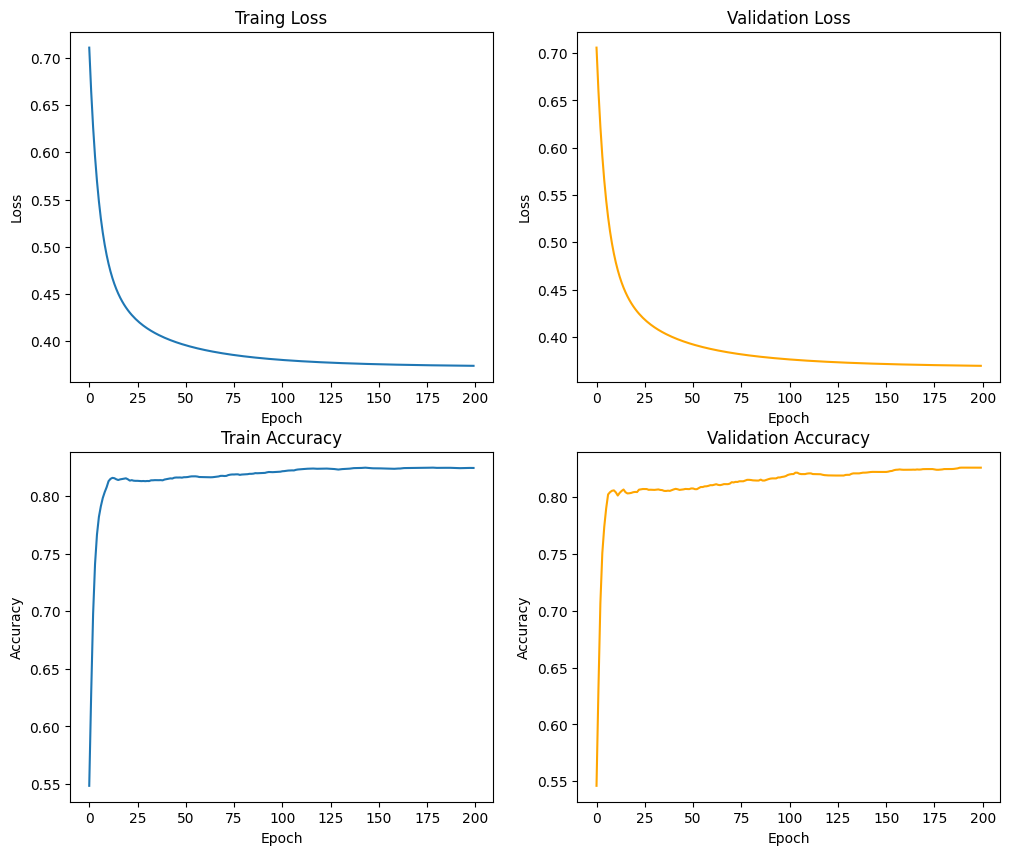

In [19]:
# Plot charts
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].plot(outputs['train_losses'])
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Traing Loss')

ax[0, 1].plot(outputs['val_losses'], 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(outputs['train_accuracy'])
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Train Accuracy')

ax[1, 1].plot(outputs['val_accuracy'], 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

In [20]:
# Evaluate the model
theta = outputs['theta']
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)
print('Evaluation on validation and test set:')
print(f"\tAccuracy for validation: {val_set_acc}")
print(f"\tAccuracy for test: {test_set_acc}")

Evaluation on validation and test set:
	Accuracy for validation: 0.8257575757575758
	Accuracy for test: 0.8383838383838383
